In [28]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

### Call Data (Facebook, Google, Microsoft)

In [43]:
filtered = pd.read_csv(r'C:\Users\dhjrz\nlp\ionlab\filtered_stock.csv')
selected_stocks = ['FB', 'GOOG', 'MSFT']
df = filtered[filtered['Stock'].isin(selected_stocks)]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock,movement,Rate
9780,2014-01-06,-0.100259,-0.100156,-0.100244,-0.100122,-0.099878,3.282742,FB,1,0.048387
9781,2014-01-07,-0.100094,-0.100092,-0.100084,-0.100086,-0.099841,3.747399,FB,1,0.012587
9782,2014-01-08,-0.100099,-0.100099,-0.100083,-0.100070,-0.099826,2.605890,FB,1,0.005352
9783,2014-01-09,-0.100046,-0.100071,-0.100113,-0.100121,-0.099877,4.584186,FB,0,-0.017345
9784,2014-01-10,-0.100123,-0.100104,-0.100092,-0.100085,-0.099840,1.814318,FB,1,0.012583


In [44]:
# 'Date' 열을 datetime으로 변환하고 인덱스로 설정
df.drop(columns='Prev Adj', errors='ignore', inplace=True)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Volume', 'Adj Close','Close']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Volume', 'Adj Close','Close']])

C:\Users\dhjrz\AppData\Local\Temp\ipykernel_46268\1820078373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='Prev Adj', errors='ignore', inplace=True)
C:\Users\dhjrz\AppData\Local\Temp\ipykernel_46268\1820078373.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Open', 'High', 'Low', 'Volume', 'Adj Close','Close']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Volume', 'Adj Close','Close']])


In [45]:
len(df[df['movement']==1])

544

In [46]:
df.describe

<bound method NDFrame.describe of              Date      Open      High       Low     Close  Adj Close  \
9780   2014-01-06  0.026541  0.028733  0.026520  0.029961   0.034215   
9781   2014-01-07  0.030962  0.030466  0.030849  0.030932   0.035181   
9782   2014-01-08  0.030828  0.030278  0.030863  0.031350   0.035597   
9783   2014-01-09  0.032243  0.031017  0.030071  0.029988   0.034241   
9784   2014-01-10  0.030194  0.030130  0.030631  0.030959   0.035208   
...           ...       ...       ...       ...       ...        ...   
16057  2015-12-22  0.027309  0.026341  0.027135  0.027467   0.028522   
16058  2015-12-23  0.028266  0.026878  0.028418  0.028101   0.029126   
16059  2015-12-28  0.027795  0.026972  0.027790  0.028276   0.029293   
16060  2015-12-29  0.029062  0.028182  0.029265  0.029085   0.030064   
16061  2015-12-31  0.028725  0.027295  0.028391  0.027642   0.028689   

         Volume Stock  movement      Rate  
9780   0.339949    FB         1  0.048387  
9781   0.3812

#여기부터

In [47]:
def create_sequences(df, window_size):
    sequences = []
    labels = []

    stocks = df['Stock'].unique()

    for stock in stocks:
        stock_data = df[df['Stock'] == stock].drop(columns=['Stock','Date'])
        stock_data = stock_data.sort_index()
        stock_data = stock_data.to_numpy()

        for i in range(len(stock_data) - window_size):
            seq = stock_data[i:i + window_size, :-2]  # 모든 열을 포함하되 Movement 열은 제외
            movement = stock_data[i + window_size, -2]  # Movement 열을 레이블로 사용
            sequences.append(seq)
            labels.append(movement)

    return np.array(sequences), np.array(labels)

# 시퀀스 생성
window_size = 5
# sequences, labels = create_sequences(combined_df, window_size)

In [48]:
train_df = df[(df['Date']>='2014-01-01') & (df['Date']<='2015-08-01')]
valid_df = df[(df['Date']>='2014-08-01') & (df['Date']<='2015-10-01')]
test_df = df[(df['Date']>='2015-10-01') & (df['Date']<='2016-01-01')]

# 각각의 데이터셋에 대해 시퀀스 생성
train_sequences, train_labels = create_sequences(train_df, window_size)
val_sequences, val_labels = create_sequences(valid_df, window_size)
test_sequences, test_labels = create_sequences(test_df, window_size)

In [49]:
print(f"Training sequences shape: {train_sequences.shape}")
print(f"Validation sequences shape: {val_sequences.shape}")
print(f"Test sequences shape: {test_sequences.shape}")

Training sequences shape: (767, 5, 6)
Validation sequences shape: (564, 5, 6)
Test sequences shape: (120, 5, 6)


In [50]:
train_labels

array([0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
       1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 1., 1., 1., 1.

In [51]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# NumPy 배열을 PyTorch 텐서로 변환
train_sequences_tensor = torch.tensor(train_sequences, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

val_sequences_tensor = torch.tensor(val_sequences, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

test_sequences_tensor = torch.tensor(test_sequences, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# DataLoader 생성
batch_size = 32

train_dataset = TensorDataset(train_sequences_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_sequences_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_sequences_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


### RNN

In [52]:
import torch.nn as nn

class RNNModel(nn.Module):
    # def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout = 0.3):
    #     super(RNNModel, self).__init__()
    #     self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    #     self.fc = nn.Linear(hidden_size, output_size)
    #     # self.softmax = nn.Softmax(dim=1)  # 예측 결과를 확률로 변환
    #     self.dropout = nn.Dropout(p=dropout)
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.3):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size, output_size), nn.Sigmoid())
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)  # 초기 은닉 상태
        out, _ = self.rnn(x, h0)  # RNN 레이어 통과
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)  # 마지막 타임스텝의 출력을 선형 레이어에 통과
        # out = self.softmax(out)   
        return out

num_layers = 1
input_size = 6
hidden_size = 16
output_size = 2  # 1 또는 0

model = RNNModel(input_size, hidden_size, output_size, num_layers)

In [53]:
# 내부적으로 소프트맥스 적용하여 로짓-> 확률 변환, 확률과 실제 레이블 간 차이 계산
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for features, labels in train_loader:
        outputs = model(features)
        # labels = labels.unsqueeze(1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete')


Epoch [5/50], Loss: 0.6963
Epoch [10/50], Loss: 0.6802
Epoch [15/50], Loss: 0.7119
Epoch [20/50], Loss: 0.6798
Epoch [25/50], Loss: 0.7035
Epoch [30/50], Loss: 0.6837
Epoch [35/50], Loss: 0.7191
Epoch [40/50], Loss: 0.6863
Epoch [45/50], Loss: 0.7033
Epoch [50/50], Loss: 0.6981
Training complete


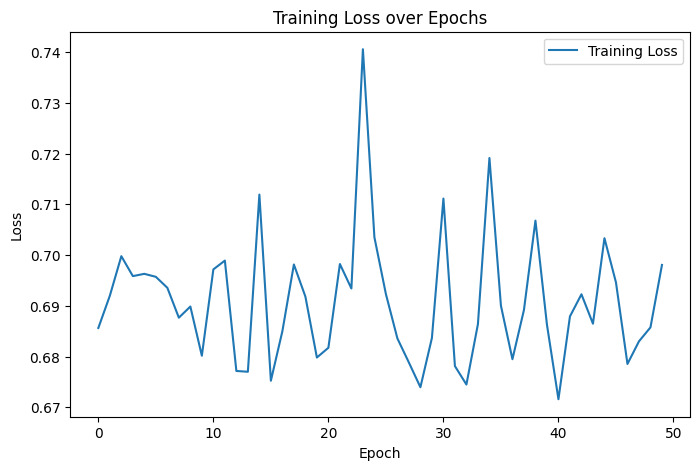

In [54]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
def evaluate_model(loader, model):
    model.eval()  # 평가 모드로 전환
    total = 0
    correct = 0
    tp = tn = fp = fn = 0

    # 평가 단계이므로 파라미터 업데이트X
    with torch.no_grad():
        for sequences, labels in loader:
            outputs = model(sequences)
            # out = 각 클래스(오를 확률, 내릴 확률)에 대한 logit
            # max함수를 통해 로짓에서 큰 값을 가진 인덱스 반환
            # 최대값의 인덱스 = 예측된 클래스 레이블
            _, predicted = torch.max(outputs, 1)

            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()

            tp += ((predicted == 1) & (labels == 1)).sum().item()
            tn += ((predicted == 0) & (labels == 0)).sum().item()
            fp += ((predicted == 1) & (labels == 0)).sum().item()
            fn += ((predicted == 0) & (labels == 1)).sum().item()
            # print(f'labels: {labels}')
            # print(f'predicted: {predicted}')
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    macc = (tp * tn - fp * fn) / denominator if denominator != 0 else 0

    print(f'ACC: {accuracy:.4f}, MACC: {macc:.4f}')
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')

In [ ]:
train_acc = evaluate_model(train_loader, model)

In [ ]:
val_acc = evaluate_model(val_loader, model)

In [ ]:
test_acc = evaluate_model(test_loader, model)

### Price + Sentiment Scores

In [ ]:
sentiment = pd.read_csv('sentiment.csv')
sentiment.drop(columns=['Unnamed: 0'], inplace=True)
sentiment.rename(columns={'filename':'Date'}, inplace=True)
sentiment['Date'] = pd.to_datetime(sentiment['Date'])
sentiment

In [ ]:
filtered['Date']= pd.to_datetime(filtered['Date'])
total = pd.merge(sentiment, filtered,on=["Date",'Stock'])
total

In [ ]:
stocks = total['Stock'].unique()
for stock in stocks:
        stock_data = total[total['Stock'] == stock].drop(columns=['Stock', 'Date', 'cleaned_tweet', 'label'])
        stock_data = stock_data.sort_index()
        movement = stock_data.iloc[0,-4]
print(stock_data)

In [ ]:
import numpy as np

def data_sequences(df, window_size):
    total_sequences = []
    total_sentiments = []
    total_labels = []

    stocks = df['Stock'].unique()

    for stock in stocks:
        stock_data = df[df['Stock'] == stock].drop(columns=['Stock', 'Date', 'cleaned_tweet', 'label','Unnamed: 0'])
        stock_data = stock_data.sort_index()
        stock_data = stock_data.to_numpy()

        for i in range(len(stock_data) - window_size):
            seq = stock_data[i:i + window_size, 4:10]  # Open, High, Low, Close, Adj Close, Volume을 포함
            sentiment = stock_data[i:i + window_size, :3]  # positive, negative, neutral 열만 포함
            movement = stock_data[i + window_size, -2]  # movement 열을 레이블로 사용

            total_sequences.append(seq)
            total_sentiments.append(sentiment)
            total_labels.append(movement)

    # 전체 시퀀스와 감정 데이터의 형태를 확인합니다.
    total_sequences = np.array(total_sequences)
    total_sentiments = np.array(total_sentiments)
    total_labels = np.array(total_labels)

    return total_sequences, total_sentiments, total_labels

# 예시 데이터 프레임 생성 및 시퀀스 생성
window_size = 5
total_sequences, total_sentiments, total_labels = data_sequences(total, window_size)


In [ ]:
total_train_df = total[(total['Date']>='2014-01-01') & (total['Date']<='2015-08-01')]
total_valid_df = total[(total['Date']>='2014-08-01') & (total['Date']<='2015-10-01')]
total_test_df = total[(total['Date']>='2015-10-01') & (total['Date']<='2016-01-01')]

total_train_sequences, total_train_sentiments, total_train_labels = data_sequences(total_train_df, window_size)
total_val_sequences, total_val_sentiments, total_val_labels = data_sequences(total_valid_df, window_size)
total_test_sequences, total_test_sentiments, total_test_labels = data_sequences(total_test_df, window_size)

In [ ]:
print(f'total_train_sequences shape: {total_train_sequences.shape}')
print(f'total_train_sentiments shape: {total_train_sentiments.shape}')
print(f'total_train_labels shape: {total_train_labels.shape}')

In [ ]:
print(total_train_sequences)

In [ ]:
total_train_df = total[(total['Date']>='2014-01-01') & (total['Date']<='2015-08-01')]
total_valid_df = total[(total['Date']>='2014-08-01') & (total['Date']<='2015-10-01')]
total_test_df = total[(total['Date']>='2015-10-01') & (total['Date']<='2016-01-01')]

total_train_sequences, total_train_sentiments, total_train_labels = data_sequences(total_train_df, window_size)
total_val_sequences, total_val_sentiments, total_val_labels = data_sequences(total_valid_df, window_size)
total_test_sequences, total_test_sentiments, total_test_labels = data_sequences(total_test_df, window_size)

# # 각각의 데이터셋에 대해 시퀀스 생성
def prepare_data(price_sequence, sentiment_sequence, labels):
    price_sequences = torch.tensor(np.array(price_sequence), dtype=torch.float32)
    sentiment_sequences = torch.tensor(np.array(sentiment_sequence), dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long).unsqueeze(1)  # 이진 분류를 위해 shape를 (N, 1)로 맞춤
    return price_sequences, sentiment_sequences, labels

# # 데이터 준비
train_price_sequences, train_sentiment_sequences, train_labels = prepare_data(total_train_sequences, total_train_sentiments,total_train_labels)
val_price_sequences, val_sentiment_sequences, val_labels = prepare_data(total_val_sequences, total_val_sentiments,total_val_labels)
test_price_sequences, test_sentiment_sequences, test_labels = prepare_data(total_test_sequences, total_test_sentiments,total_test_labels)


# 데이터 로더 생성
batch_size = 32
total_train_dataset = TensorDataset(train_price_sequences, train_sentiment_sequences, train_labels)
total_val_dataset = TensorDataset(val_price_sequences, val_sentiment_sequences, val_labels)
total_test_dataset = TensorDataset(test_price_sequences, test_sentiment_sequences, test_labels)


total_train_loader = DataLoader(total_train_dataset, batch_size=batch_size, shuffle=False)
total_val_loader = DataLoader(total_val_dataset, batch_size=batch_size, shuffle=False)
total_test_loader = DataLoader(total_test_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
print(f"Train price sequences shape: {total_train_sequences.shape}")
print(f"Train sentiment sequences shape: {total_train_sentiments.shape}")
print(f"Train labels shape: {total_train_labels.shape}")

print(f"Val price sequences shape: {total_val_sequences.shape}")
print(f"Val sentiment sequences shape: {total_val_sentiments.shape}")
print(f"Val labels shape: {total_val_labels.shape}")

print(f"Test price sequences shape: {total_test_sequences.shape}")
print(f"Test sentiment sequences shape: {total_test_sentiments.shape}")
print(f"Test labels shape: {total_test_labels.shape}")


### RNN

In [ ]:
class RNNWithSentiment(nn.Module):
    def __init__(self, input_size_price, hidden_size, output_size, input_size_sentiment, num_layers, dropout=0.3):
        super(RNNWithSentiment, self).__init__()
        self.input_size_price = input_size_price
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size_sentiment = input_size_sentiment
        self.dropout = nn.Dropout(p=dropout)
        self.rnn = nn.RNN(input_size_price, hidden_size, num_layers, batch_first=True)
        # Fully connected layer의 입력 크기는 hidden_size와 sentiment_sequences 평탄화 크기의 합
        self.fc = nn.Linear(hidden_size + (input_size_sentiment * window_size), output_size)  # window_size는 시퀀스 길이

    def forward(self, x, sentiment_sequences):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, hn = self.rnn(x, h0)
        last_hidden = hn[-1]  # 마지막 hidden state 사용

        # sentiment_sequences를 평탄화하여 (batch_size, seq_len * input_size_sentiment) 형태로 변환
        sentiment_data = sentiment_sequences.view(sentiment_sequences.size(0), -1)

        # last_hidden과 sentiment_data를 결합
        combined = torch.cat((last_hidden, sentiment_data), dim=1)

        combined = self.dropout(combined)
        output = self.fc(combined)
        return output


input_size_price = total_train_sequences.shape[2]  # 특성 수
input_size_sentiment = total_train_sentiments.shape[2]
hidden_size = 16
output_size = 2  # 이진 분류
num_layers=1

model = RNNWithSentiment(input_size_price,hidden_size,output_size,input_size_sentiment,num_layers)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for sequences, sentiments,labels in total_train_loader:
        outputs = model(sequences,sentiments)
        labels = labels.squeeze(1).long()
        loss = criterion(outputs, labels)
        # labels = labels.float().view(-1, 1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete')

In [ ]:
def evaluate_add_model(loader, model):
    model.eval()  # 평가 모드로 전환
    total = 0
    correct = 0
    tp = tn = fp = fn = 0

    # 평가 단계이므로 파라미터 업데이트X
    with torch.no_grad():
        for features, sentiment_data, labels in loader:
            outputs = model(features, sentiment_data)
            # out = 각 클래스(오를 확률, 내릴 확률)에 대한 logit
            # max함수를 통해 로짓에서 큰 값을 가진 인덱스 반환
            _, predicted = torch.max(outputs, 1)

            # total += labels.size(0)
            # correct += (predicted == labels).sum().item()

            tp += ((predicted == 1) & (labels == 1)).sum().item()
            tn += ((predicted == 0) & (labels == 0)).sum().item()
            fp += ((predicted == 1) & (labels == 0)).sum().item()
            fn += ((predicted == 0) & (labels == 1)).sum().item()

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    macc = (tp*tn-fp*fn) / np.sqrt(float (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))

    print(f'ACC: {accuracy:.4f}, MACC: {macc:.4f}')
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')

In [ ]:
train_acc = evaluate_add_model(total_train_loader, model)

In [ ]:
val_acc = evaluate_add_model(total_val_loader, model)

In [ ]:
test_acc = evaluate_add_model(total_test_loader, model)
# 다 1로 예측

### RNN+RNN

In [ ]:
class RNNSentiment(nn.Module):
    def __init__(self, input_size_price, hidden_size_price, input_size_sentiment, hidden_size_sentiment, output_size, num_layers, dropout=0.3):
        super(RNNSentiment, self).__init__()
        self.hidden_size_price = hidden_size_price
        self.hidden_size_sentiment = hidden_size_sentiment
        self.num_layers = num_layers

        self.rnn_price = nn.RNN(input_size_price, hidden_size_price, num_layers, batch_first=True)
        self.rnn_sentiment = nn.RNN(input_size_sentiment, hidden_size_sentiment, num_layers, batch_first=True)

        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size_price + hidden_size_sentiment, output_size)

    def forward(self, price_sequences, sentiment_sequences):
        h0_price = torch.zeros(self.num_layers, price_sequences.size(0), self.hidden_size_price).to(price_sequences.device)
        h0_sentiment = torch.zeros(self.num_layers, sentiment_sequences.size(0), self.hidden_size_sentiment).to(sentiment_sequences.device)

        _, hn_price = self.rnn_price(price_sequences, h0_price)
        _, hn_sentiment = self.rnn_sentiment(sentiment_sequences, h0_sentiment)

        last_hidden_price = hn_price[-1]  # 마지막 hidden state 사용
        last_hidden_sentiment = hn_sentiment[-1]  # 마지막 hidden state 사용

        combined = torch.cat((last_hidden_price, last_hidden_sentiment), dim=1)
        combined = self.dropout(combined)
        output = self.fc(combined)
        return output

input_size_price = total_train_sequences.shape[2]  # 특성 수
input_size_sentiment = total_train_sentiments.shape[2]
hidden_size_price = 16
hidden_size_sentiment = 16
output_size = 2  # 이진 분류
num_layers = 1

model2 = RNNSentiment(input_size_price, hidden_size_price, input_size_sentiment, hidden_size_sentiment, output_size, num_layers)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model2.train()
    epoch_loss = 0
    for sequences, sentiments, labels in total_train_loader:
        outputs = model2(sequences, sentiments)
        labels = labels.squeeze(1).long()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete')


In [ ]:
train_acc = evaluate_add_model(total_train_loader, model2)

In [ ]:
val_acc = evaluate_add_model(total_val_loader, model2)

In [ ]:
test_acc = evaluate_add_model(total_test_loader, model2)
# 대부분 1로 예측(0도 있긴 있음)

### RNN+MLP

In [ ]:
class RNNWithMLP(nn.Module):
    def __init__(self, input_size_price, hidden_size_price, input_size_sentiment, hidden_size_sentiment, output_size, num_layers, dropout=0.3):
        super(RNNWithMLP, self).__init__()
        self.hidden_size_price = hidden_size_price
        self.hidden_size_sentiment = hidden_size_sentiment
        self.num_layers = num_layers

        # RNN 정의
        self.rnn = nn.RNN(input_size_price, hidden_size_price, num_layers, batch_first=True)

        # 감정 데이터에 대한 MLP 정의
        self.mlp = nn.Sequential(
            nn.Linear(input_size_sentiment, hidden_size_sentiment),
            nn.ReLU(),
            nn.Linear(hidden_size_sentiment, hidden_size_sentiment)
        )

        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size_price + hidden_size_sentiment, output_size)

    def forward(self, price_sequences, sentiment_sequences):
        batch_size = price_sequences.size(0)

        # RNN 처리
        h0_price = torch.zeros(self.num_layers, batch_size, self.hidden_size_price).to(price_sequences.device)
        _, hn_price = self.rnn(price_sequences, h0_price)
        last_hidden_price = hn_price[-1]  # 마지막 hidden state 사용

        # 전체 시퀀스의 감정 데이터에 대해 MLP 적용
        sentiment_features = self.mlp(sentiment_sequences.view(-1, sentiment_sequences.size(-1)))
        sentiment_features = sentiment_features.view(sentiment_sequences.size(0), sentiment_sequences.size(1), -1)

        # 마지막 시퀀스의 MLP 결과만 사용하는 대신, 전체 시퀀스의 평균 또는 합산 결과를 사용할 수 있습니다.
        sentiment_data = sentiment_features.mean(dim=1)  # 전체 시퀀스의 평균값

        # 결과 결합
        out = torch.cat((last_hidden_price, sentiment_data), dim=1)
        combined = self.dropout(out)
        output = self.fc(combined)
        return output

model3 = RNNWithMLP(input_size_price, hidden_size_price, input_size_sentiment, hidden_size_sentiment, output_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)
for epoch in range(num_epochs):
    model3.train()
    epoch_loss = 0
    for sequences, sentiments, labels in total_train_loader:
        outputs = model3(sequences, sentiments)
        labels = labels.squeeze(1).long()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete')

In [ ]:
train_acc3 = evaluate_add_model(total_train_loader, model3)

In [ ]:
val_acc3 = evaluate_add_model(total_val_loader, model3)

In [ ]:
test_acc3 = evaluate_add_model(total_test_loader, model3)

### Attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.query_fc = nn.Linear(hidden_size, hidden_size)
        self.key_fc = nn.Linear(hidden_size, hidden_size)
        self.value_fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, query, keys, values):
        # Query, Key, Value의 차원: [batch_size, seq_len, hidden_size]
        query = self.query_fc(query)  # [batch_size, seq_len, hidden_size]
        keys = self.key_fc(keys)      # [batch_size, seq_len, hidden_size]
        values = self.value_fc(values) # [batch_size, seq_len, hidden_size]

        # Scoring
        scores = torch.bmm(query, keys.transpose(1, 2))  # [batch_size, seq_len, seq_len]
        weights = F.softmax(scores, dim=-1)  # [batch_size, seq_len, seq_len]

        # Weighted sum
        attended_values = torch.bmm(weights, values)  # [batch_size, seq_len, hidden_size]
        return attended_values
class RNNWithAttention(nn.Module):
    def __init__(self, input_size_price, hidden_size, output_size, input_size_sentiment, num_layers, dropout=0.3):
        super(RNNWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size_price, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)
        self.sentiment_mlp = nn.Linear(input_size_sentiment, hidden_size)  # 감정 데이터의 MLP
        self.fc = nn.Linear(hidden_size * 2, output_size)  # RNN hidden state + Attention output
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, sentiment_sequences):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        rnn_out, hn = self.rnn(x, h0)
        last_hidden = hn[-1]  # 마지막 hidden state 사용

        # 감정 데이터에 MLP 적용
        sentiment_out = self.sentiment_mlp(sentiment_sequences)  # [batch_size, seq_len, hidden_size]

        # 어텐션 적용
        # RNN의 출력 마지막 상태를 Query로 사용
        last_hidden_expanded = last_hidden.unsqueeze(1)  # [batch_size, 1, hidden_size]
        attention_out = self.attention(last_hidden_expanded, sentiment_out, sentiment_out)
        attention_out = attention_out.squeeze(1)  # [batch_size, hidden_size]

        # 결합
        combined_out = torch.cat((last_hidden, attention_out), dim=1)
        combined_out = self.dropout(combined_out)
        output = self.fc(combined_out)
        return output
model4 = RNNWithMLP(input_size_price, hidden_size_price, input_size_sentiment, hidden_size_sentiment, output_size, num_layers)

for epoch in range(num_epochs):
    model4.train()
    epoch_loss = 0
    for sequences, sentiments, labels in total_train_loader:
        outputs = model4(sequences, sentiments)
        labels = labels.squeeze(1).long()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete')

In [ ]:
train_acc4 = evaluate_add_model(total_train_loader, model4)

In [ ]:
val_acc4 = evaluate_add_model(total_val_loader, model4)

In [ ]:
test_acc4 = evaluate_add_model(total_test_loader, model4)

### Calculating Correlation

In [ ]:
from scipy.stats import pearsonr

# 필요한 열만 선택
correlation_data = total[['positive', 'negative', 'neutral','sentiment_score', 'movement']]

# 상관계수 계산
correlation_matrix = correlation_data.corr()

print(correlation_matrix)

In [ ]:
# 필요한 열만 선택
correlation_data = total[['Open','High','Low','Volume','Close','Adj Close', 'movement']]

# 상관계수 계산
correlation_matrix = correlation_data.corr()

print(correlation_matrix)

In [ ]:
# 필요한 열만 선택
# 정규화 하기 전
correlation_data = combined_df[['Open','High','Low','Volume','Close','Adj Close', 'movement']]

# 상관계수 계산
correlation_matrix = correlation_data.corr()

print(correlation_matrix)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.3):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM 정의
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # LSTM 처리
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Attention 적용
        attn_weights = F.softmax(self.attention(out), dim=1)
        context_vector = torch.sum(attn_weights * out, dim=1)
        return context_vector

class RNNWithMLP(nn.Module):
    def __init__(self, input_size_price, hidden_size_price, input_size_sentiment, hidden_size_sentiment, output_size, num_layers, dropout=0.3):
        super(RNNWithMLP, self).__init__()
        self.hidden_size_price = hidden_size_price
        self.hidden_size_sentiment = hidden_size_sentiment
        self.num_layers = num_layers

        # Attention LSTM 정의
        self.alstm = AttentionLSTM(input_size_price, hidden_size_price, num_layers, dropout)

        # 감정 데이터에 대한 MLP 정의
        self.mlp = nn.Sequential(
            nn.Linear(input_size_sentiment, hidden_size_sentiment),
            nn.ReLU(),
            nn.Linear(hidden_size_sentiment, hidden_size_sentiment)
        )

        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size_price + hidden_size_sentiment, output_size)

    def forward(self, price_sequences, sentiment_sequences):
        # ALSTM 처리
        price_features = self.alstm(price_sequences)

        # 감정 데이터에 대한 MLP 처리
        sentiment_features = self.mlp(sentiment_sequences.view(-1, sentiment_sequences.size(-1)))
        sentiment_features = sentiment_features.view(sentiment_sequences.size(0), sentiment_sequences.size(1), -1)
        sentiment_data = sentiment_features.mean(dim=1)  # 마지막 시퀀스만 사용

        # 결과 결합
        out = torch.cat((price_features, sentiment_data), dim=1)
        combined = self.dropout(out)
        output = self.fc(combined)
        return output

# 모델 정의
model5 = RNNWithMLP(input_size_price, hidden_size_price, input_size_sentiment, hidden_size_sentiment, output_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr=0.001)

# 학습 루프
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model5.train()
    epoch_loss = 0
    for sequences, sentiments, labels in total_train_loader:
        outputs = model5(sequences, sentiments)
        labels = labels.squeeze(1).long()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(total_train_loader))

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(total_train_loader):.4f}')

print('Training complete')


In [ ]:
train_acc3 = evaluate_add_model(total_train_loader, model5)

In [ ]:
val_acc3 = evaluate_add_model(total_val_loader, model5)